In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, random, joblib, statistics
import sklearn as sk
import optuna
import xgboost as xgb
import plotly
import json
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm, datasets
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GroupKFold
import functions
import functionasy_svm
import math
from typing import List, Optional, Tuple

random.seed(1213870)

/home/ucloud/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Meta Analysis Plot
meta analysis = 0.63 - 0.97

In [3]:

# Define folder paths for XGB and SVM results
folder_path_xgb = f"./results/xgb/test"

# Collect files from both folders
files_xgb = [
os.path.join(root, file)
for root, _, files in os.walk(folder_path_xgb)
for file in files
if '_classification_report' in file
]

# Initialize lists to store results
f1_scores_td = []
f1_scores_asd = []
f1_means = []
test_names = []
test_types = []

# Process files from both models
for file_path in files_xgb:

    filename = os.path.basename(file_path)
    name_suffix = filename.find('_participant_classification_report')
    test_name = filename[:name_suffix]
    test_names.append(test_name)
    if "MG" in test_name and "Qfam" in test_name:
        test_type = 'Between Task'
    elif "Qfam" in test_name and "Qunfam" in test_name:
        test_type = 'Between Familiarity'  
    else:
        test_type = 'Within'
    test_types.append(test_type)

    # Load classification report
    classification_report = pd.read_csv(file_path)

    # Extract F1 scores
    f1_td = classification_report.iloc[2, 0]
    f1_asd = classification_report.iloc[2, 1]
    f1_mean = np.mean([f1_td, f1_asd])
    f1_scores_td.append(f1_td)
    f1_scores_asd.append(f1_asd)
    f1_means.append(f1_mean)

# Combine results into a DataFrame
results = pd.DataFrame({
    'test_type': test_types,
    'test_name': test_names,
    'F1_score_td': f1_scores_td,
    'F1_score_asd': f1_scores_asd,
    'f1_mean': f1_means
})

# Sort the DataFrame by test_type
results = results.sort_values('test_type')
print(results)

              test_type         test_name  F1_score_td  F1_score_asd   f1_mean
4   Between Familiarity    Qunfam_Qfam_80     0.631579      0.851064  0.741321
5   Between Familiarity    Qunfam_Qfam_20     0.222222      0.666667  0.444444
8   Between Familiarity    Qfam_Qunfam_80     0.800000      0.878049  0.839024
10  Between Familiarity    Qfam_Qunfam_20     0.545455      0.736842  0.641148
0          Between Task        MG_Qfam_20     0.666667      0.777778  0.722222
2          Between Task        MG_Qfam_80     0.880000      0.926829  0.903415
6          Between Task        Qfam_MG_20     0.545455      0.736842  0.641148
7          Between Task        Qfam_MG_80     0.857143      0.894737  0.875940
1                Within          MG_MG_20     0.769231      0.823529  0.796380
3                Within  Qunfam_Qunfam_20     0.545455      0.736842  0.641148
9                Within      Qfam_Qfam_20     0.666667      0.777778  0.722222


In [13]:
# formatting results correctly:
within = results[results['test_type'] == 'Within']
task = results[results['test_type'] == 'Between Task']
familiarity = results[results['test_type'] == 'Between Familiarity']
within = within[['f1_mean', 'test_type']]
task = task[['f1_mean', 'test_type']]
familiarity = familiarity[['f1_mean', 'test_type']]
meta = [0.63, 0.97]
metas = pd.DataFrame({'f1_mean': meta, 'test_type': 'Meta Analysis'})

# Concatenate into one DataFrame
data = pd.concat([metas, within, task, familiarity,])

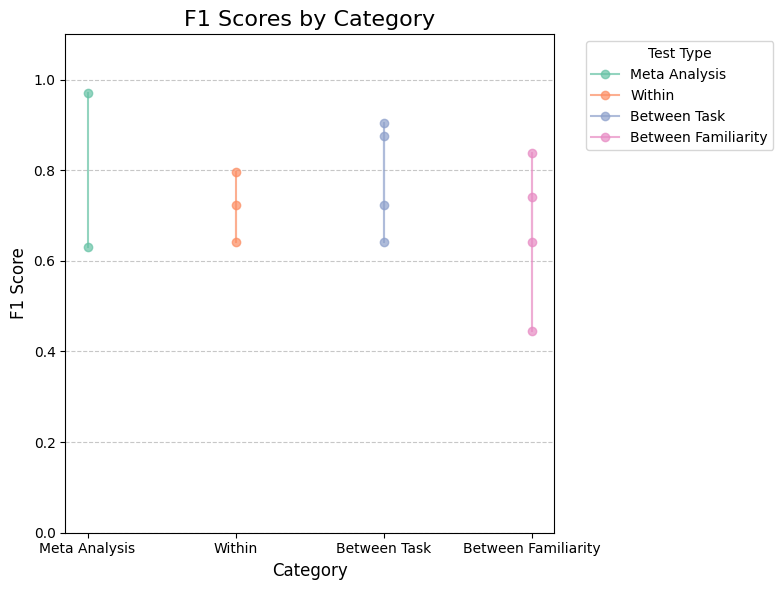

In [14]:

# Create the plot
plt.figure(figsize=(8, 6))

# Define a color palette for the categories (you can adjust this as needed)
palette = sns.color_palette("Set2", n_colors=len(data['test_type'].unique()))

# Plot lines connecting points within each category
for i, category in enumerate(data['test_type'].unique()):
    subset = data[data['test_type'] == category]
    # Plot line for each category
    plt.plot([category] * len(subset), subset['f1_mean'], 'o-', color=palette[i], alpha=0.7, label=category)

# Customize the plot
plt.title("F1 Scores by Category", fontsize=16)
plt.xlabel("Category", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.ylim(0, 1.1)  # Adjust y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend to the plot to distinguish categories
plt.legend(title="Test Type", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Show the plot
plt.show()

